In [1]:
import tensorflow as tf

# List all physical devices of type GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        gpu_name = gpu_details.get('device_name', 'Unknown GPU')
        print(f"Found a GPU with ID: {gpu}, Name: {gpu_name}")
else:
    print("Failed to detect a GPU.")


Found a GPU with ID: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, Add,
    GlobalAveragePooling2D, Dense, Dropout, Layer
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)

# Ensure Pillow is installed
!pip install Pillow

import PIL


In [3]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

# Re-use your AttentionLayer definition from above
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = tf.nn.tanh(tf.tensordot(x, self.W, axes=[-1, 0]) + self.b)
        attn = tf.nn.softmax(tf.tensordot(score, self.u, axes=[-1, 0]), axis=1)
        attn = tf.expand_dims(attn, axis=-1)
        return x * attn

def build_attention_cnn(input_shape=(224, 224, 3), num_classes=2):
    # 1. Frozen EfficientNetB0 backbone
    base = EfficientNetB0(include_top=False,
                          input_shape=input_shape,
                          weights='imagenet')
    base.trainable = False

    # 2. Input → backbone → attention → pool → FC
    inputs = Input(shape=input_shape)
    x = base(inputs, training=False)
    x = AttentionLayer()(x)                   # <-- Attention only
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs, name="EffNetB0_Attention")

# Build, compile, and inspect
attention_model = build_attention_cnn()
attention_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
attention_model.summary()


Model: "EffNetB0_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 attention_layer (AttentionL  (None, 7, 7, 1280)       1640960   
 ayer)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)        

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size   = 32
max_samples  = 10000
target_size  = (224, 224)
classes      = ['fake', 'real']

def create_dataframe_from_dir(base_dir, max_samples, classes):
    data = []
    for label in classes:
        class_dir = os.path.join(base_dir, label)
        files = [os.path.join(class_dir, f)
                 for f in os.listdir(class_dir)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(files)
        n_per_class = max_samples // len(classes)
        for f in files[:n_per_class]:
            data.append({'filename': f, 'class': label})
    return pd.DataFrame(data)

# Assemble dataframes
train_df = create_dataframe_from_dir(
    r"D:\Hybrid with 140k Real and Fake Faces\real_vs_fake\real-vs-fake\train",
    max_samples, classes)
val_df   = create_dataframe_from_dir(
    r"D:\Hybrid with 140k Real and Fake Faces\real_vs_fake\real-vs-fake\valid",
    max_samples, classes)
test_df  = create_dataframe_from_dir(
    r"D:\Hybrid with 140k Real and Fake Faces\real_vs_fake\real-vs-fake\test",
    max_samples, classes)

# Noise-injection function: adds Gaussian noise with σ=0.03
def add_gaussian_noise(img):
    noise = np.random.normal(loc=0.0, scale=0.03, size=img.shape)
    img_noisy = img + noise
    # clip back to valid range [0, 1] if your images are scaled that way
    return np.clip(img_noisy, 0.0, 1.0)

# Training-time augmentation per Table 2
data_aug_train = ImageDataGenerator(
    rotation_range=12,                   # up to ±12°
    zoom_range=[0.9, 1.1],               # slight zoom in/out up to 1.1×
    preprocessing_function=add_gaussian_noise
)

# No augmentation for val/test
data_aug_val = ImageDataGenerator()
data_aug_test = ImageDataGenerator()

# Generators
train_gen = data_aug_train.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=target_size, batch_size=batch_size,
    class_mode='categorical', shuffle=True,
    interpolation='lanczos'
)

val_gen = data_aug_val.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=target_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False,
    interpolation='lanczos'
)

test_gen = data_aug_test.flow_from_dataframe(
    test_df, x_col='filename', y_col='class',
    target_size=target_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False,
    interpolation='lanczos'
)

# Steps per epoch / validation / test
steps_per_epoch   = max_samples // batch_size
validation_steps  = max_samples // batch_size
test_steps        = max_samples // batch_size


Found 100,200 validated image filenames belonging to 2 classes.
Found 20,200 validated image filenames belonging to 2 classes.
Found 20,100 validated image filenames belonging to 2 classes.


In [2]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Wrap your DirectoryIterators so they never exhaust
def infinite_generator(generator):
    while True:
        yield from generator

# Build & compile your attention-CNN (was “baseline”)
custom_cnn_model = build_attention_cnn(
    input_shape=(224, 224, 3),
    num_classes=len(classes)
)
custom_cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

# === Initial Training ===
train_generator = infinite_generator(train_gen)
val_generator   = infinite_generator(val_gen)

history = custom_cnn_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# === Fine-tuning: Unfreeze backbone ===
# Note: index 1 holds the EfficientNetB0 in your build_attention_cnn()
base_model = custom_cnn_model.layers[1]
base_model.trainable = True

custom_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Re-wrap generators for fine-tuning
train_generator = infinite_generator(train_gen)
val_generator   = infinite_generator(val_gen)

history_fine = custom_cnn_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[reduce_lr, early_stopping]
)

# === Evaluate on test data ===
test_generator = infinite_generator(test_gen)

test_loss, test_acc = custom_cnn_model.evaluate(
    test_generator,
    steps=test_steps
)
print(f"Test Accuracy: {test_acc:.4f}")

# === Save Final Model ===
custom_cnn_model.save('model.h5')


Epoch 1/20
3125/3125 [==============================] - 365s 1s/step - loss: 0.5713 - accuracy: 0.7024 - val_loss: 0.4934 - val_accuracy: 0.7666 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - 166s 534ms/step - loss: 0.4969 - accuracy: 0.7559 - val_loss: 0.4561 - val_accuracy: 0.7913 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 118s 378ms/step - loss: 0.4602 - accuracy: 0.7845 - val_loss: 0.4441 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - 115s 370ms/step - loss: 0.4249 - accuracy: 0.8029 - val_loss: 0.4138 - val_accuracy: 0.8143 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - 118s 380ms/step - loss: 0.4013 - accuracy: 0.8168 - val_loss: 0.3996 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 118s 381ms/step - loss: 0.3894 - accuracy: 0.8215 - val_loss: 0.3839 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 7/20
3125/3125 [===============

In [3]:
# test evaluation
test_loss, test_accuracy = custom_cnn_model.evaluate(
    test_gen,
    steps=test_steps,
    verbose=1  
)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


3125/3125 [==============================] - 96s 306ms/step - loss: 0.2265 - accuracy: 0.9166
Test Accuracy: 0.9166
Test Loss: 0.2265


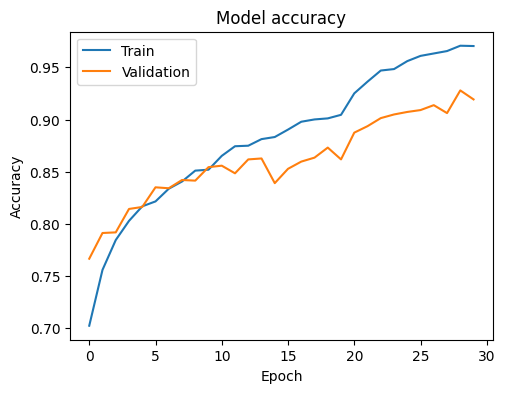

In [17]:
# Train vs validation validation accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

313/313 [==============================] - 26s 81ms/step


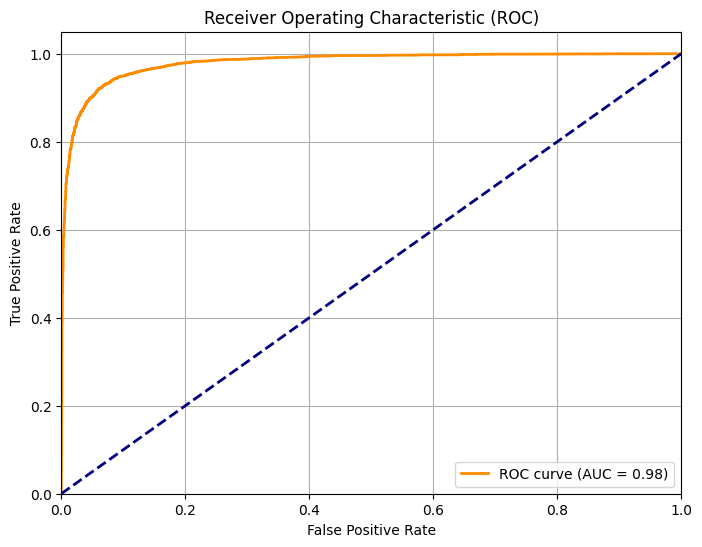

In [18]:
# Assuming you have a test generator 'test_gen' and your trained model 'custom_cnn_model'

# Step 1: Get the true labels from the generator
y_true = test_gen.classes  # true labels as integers

# Step 2: Get the predicted probabilities for the positive class (assuming binary classification)
# Use steps = ceil(num_samples / batch_size) to cover all test samples
import math
steps = math.ceil(len(y_true) / test_gen.batch_size)

# Predict probabilities
y_pred_prob_all = custom_cnn_model.predict(test_gen, steps=steps)
y_pred_prob = y_pred_prob_all[:len(y_true), 1] 

#  Compute ROC curve and AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


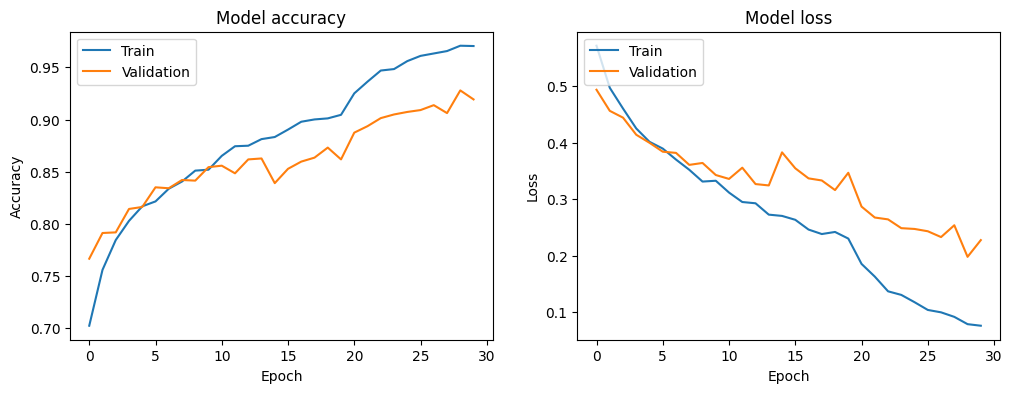

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [4]:
import numpy as np
import math

# Calculate steps to cover the entire test set
num_samples = len(test_gen.classes)
steps = math.ceil(num_samples / test_gen.batch_size)

# Evaluate the model on the test set
test_loss, test_acc = custom_cnn_model.evaluate(test_gen, steps=steps)
print('Test accuracy:', test_acc)

# Predict on the test set
predictions = custom_cnn_model.predict(test_gen, steps=steps)

# Convert predictions to class indices
y_pred = np.argmax(predictions, axis=1)

# Get true labels from the generator
y_true = test_gen.classes

# Trim predictions if they are longer than true labels (due to batch size padding)
y_pred = y_pred[:len(y_true)]

3125/3125 [==============================] - 27s 87ms/step - loss: 0.2261 - accuracy: 0.9167
Test accuracy: 0.9167
3125/3125 [==============================] - 27s 87ms/step


In [5]:
from sklearn.metrics import classification_report

target_names = list(test_gen.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=target_names))



               precision    recall  f1-score   support

        fake       0.96      0.87      0.91     10000
        real       0.88      0.96      0.92     10100

    accuracy                           0.92     21000
   macro avg       0.92      0.92      0.92     21000
weighted avg       0.92      0.92      0.92     21000



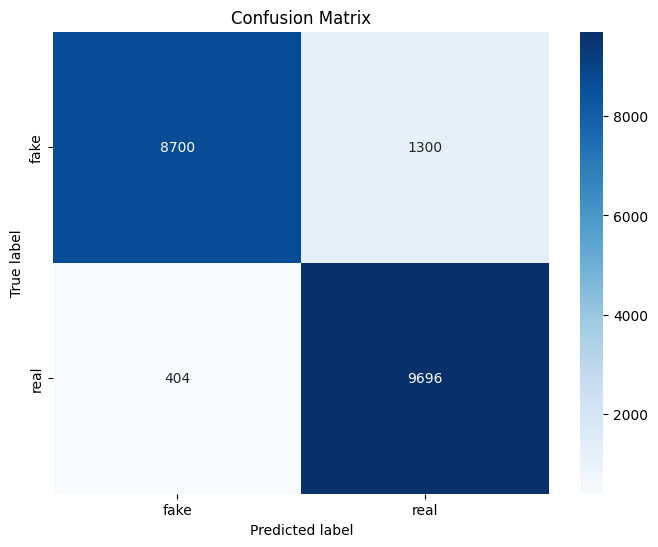

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use the original test generator (not the infinite wrapper) for class indices
class_names = list(test_gen.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
